# Setup

**Imports**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from loadmydata.load_human_locomotion import (
    load_human_locomotion_dataset,
    get_code_list,
)

**Utility functions**

In [2]:
def fig_ax(figsize=(15, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.autoscale(enable=True, axis='x', tight=True)
    return fig, ax

# Spectral feature

## Question 6

<Axes: >

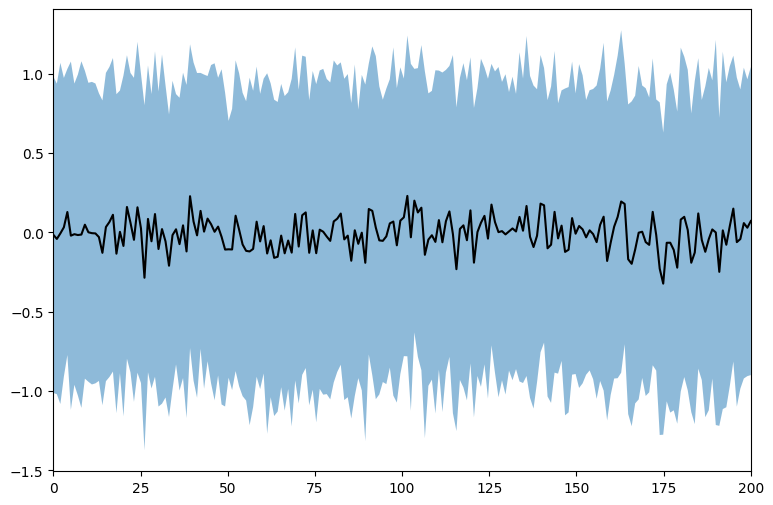

In [3]:
n_trials = 100
sample_freq = 1
save_fig = False
if save_fig:
    plt.rcParams.update({'font.size': 20}) # export figures with this line

def get_data(n_points, sample_freq):
    signal = np.random.randn(n_trials, n_points)  # shape (n_trials, n_points)
    timepoints = np.linspace(0, n_points / sample_freq, n_points) 
    return signal, timepoints

def plot_with_std(x, y):
    """
    for x of size (n, )
    y should be of size (n, m) and averaging over the second dimension
    """
    assert len(x) == len(y), f"len(x)={len(x)} != len(y)={len(y)} "
    _, ax = fig_ax((9, 6))
    avg = np.nanmean(y, axis=1) 
    std = np.nanstd(y, axis=1) 
    ax.plot(x, avg, 'k-')
    ax.fill_between(x, avg-std, avg+std, alpha=0.5)

    return ax


n_points = 200
signal, timepoints = get_data(n_points, sample_freq)
plot_with_std(timepoints, signal.T)


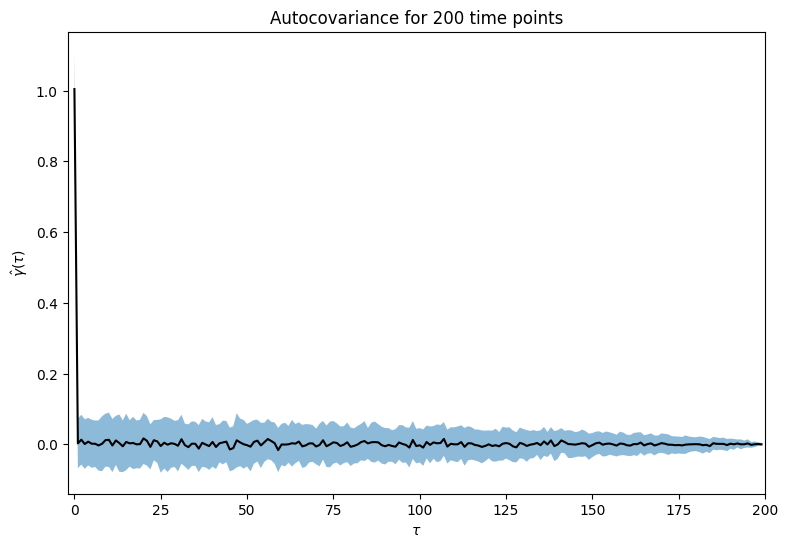

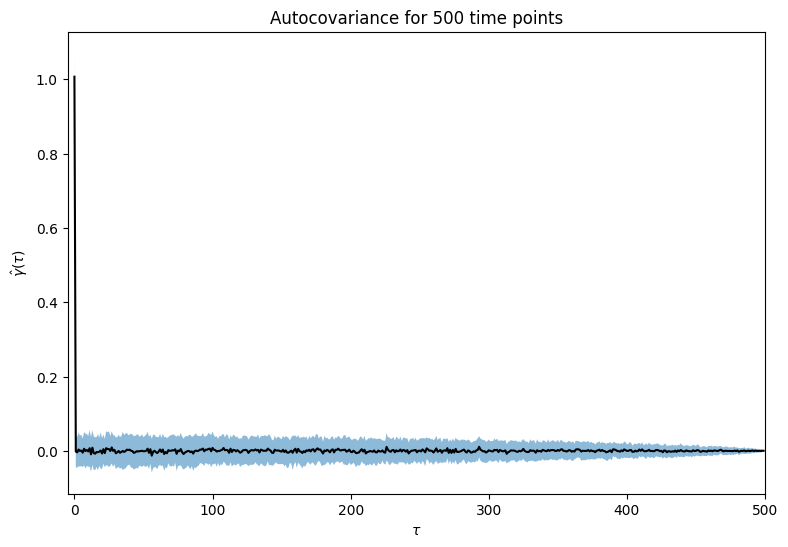

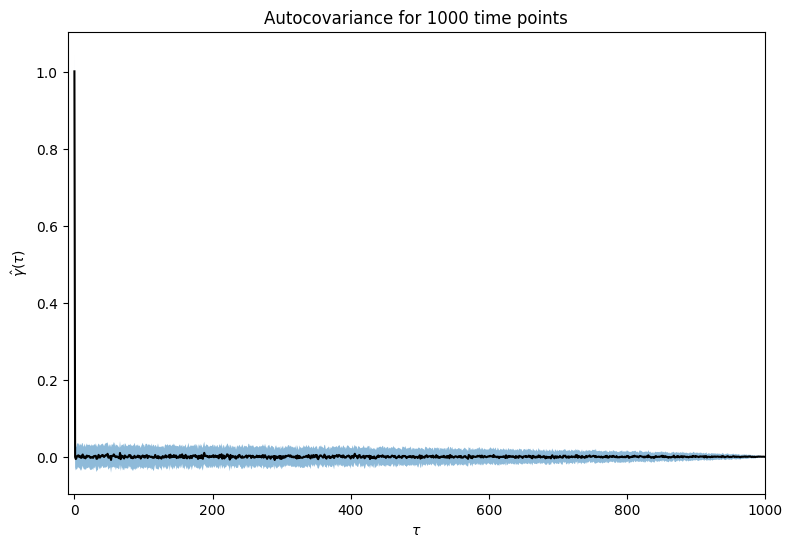

In [4]:
def sample_autocovariance(signal, tau):
    _,n_points = signal.shape
    mult = signal[:,:n_points - tau] * signal[:,tau:]
    avg_on_timepoints = np.sum(mult, axis=1) / n_points
    return avg_on_timepoints

tested_n_points = [200, 500, 1000]
for n_points in tested_n_points:
    signal, _ = get_data(n_points, sample_freq)
    taus = np.arange(n_points) # with sample_freq = 1 -> taus = timeopints 
    hat_gamma = [sample_autocovariance(signal, tau) for tau in taus]
    ax = plot_with_std(taus, hat_gamma)
    ax.set_title(f"Autocovariance for {n_points} time points")
    ax.set_ylabel("$\hat \gamma(\\tau)$")
    ax.set_xlabel("$\\tau$")
    ax.set_xlim(-1*n_points/100, n_points)
    if save_fig:
        plt.savefig(f"images/autocovariance_{n_points}.png")


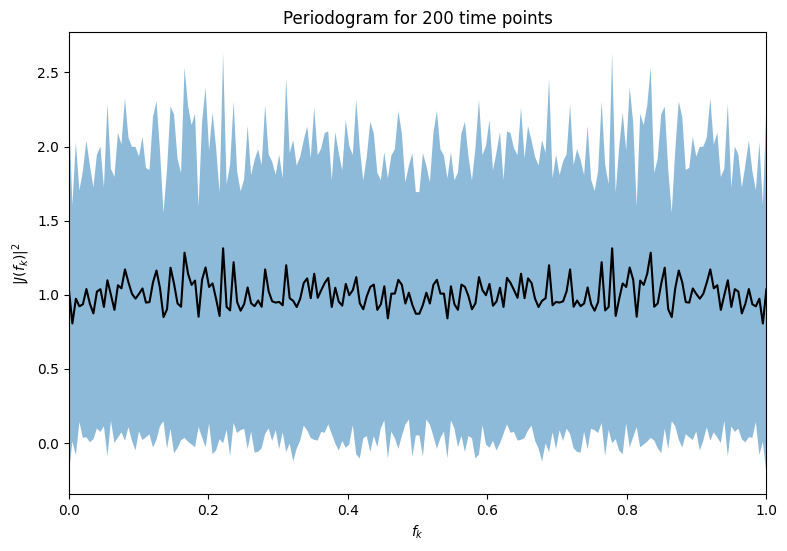

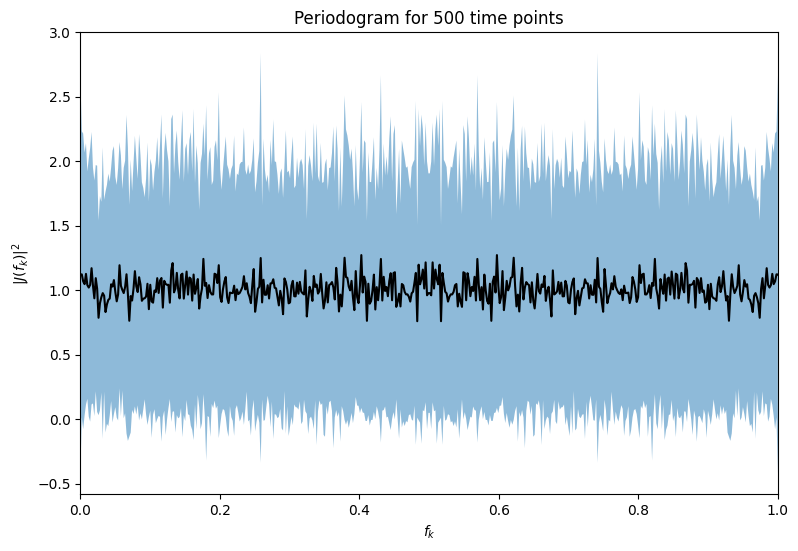

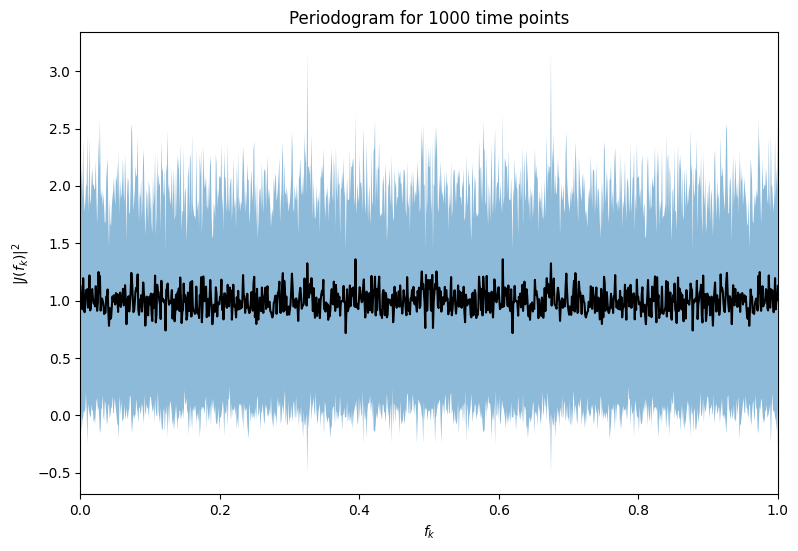

In [5]:
def periodogram_naive(signal, freq):
    _, n_points = signal.shape
    points = np.arange(n_points)
    expo = np.exp(-2 * np.pi * 1j * freq * points)
    j_fk_unormed = signal @ expo / np.sqrt(n_points)
    return np.absolute(j_fk_unormed) ** 2 

def plot_periodo(n_points):
    signal, _ = get_data(n_points, sample_freq)
    freqs = np.linspace(0,sample_freq,n_points)
    mod_jfk = np.array([periodogram_naive(signal, freq) for freq in freqs])

    ax = plot_with_std(freqs, mod_jfk)
    ax.set_title(f"Periodogram for {n_points} time points")
    ax.set_ylabel("$|J (f_k)|^2$")
    ax.set_xlabel("$f_k$")
    if save_fig: 
        plt.savefig(f"images/periodogram_{n_points}.png")

for n_points in tested_n_points:
    plot_periodo(n_points)

## Question 9

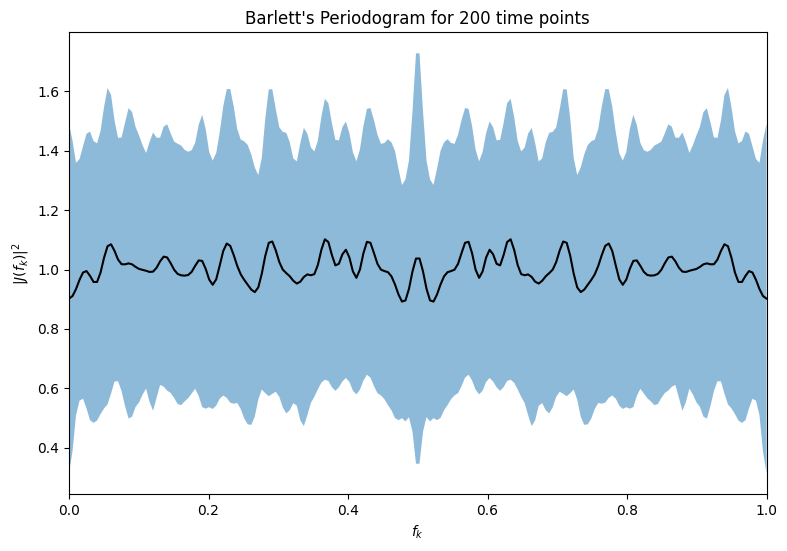

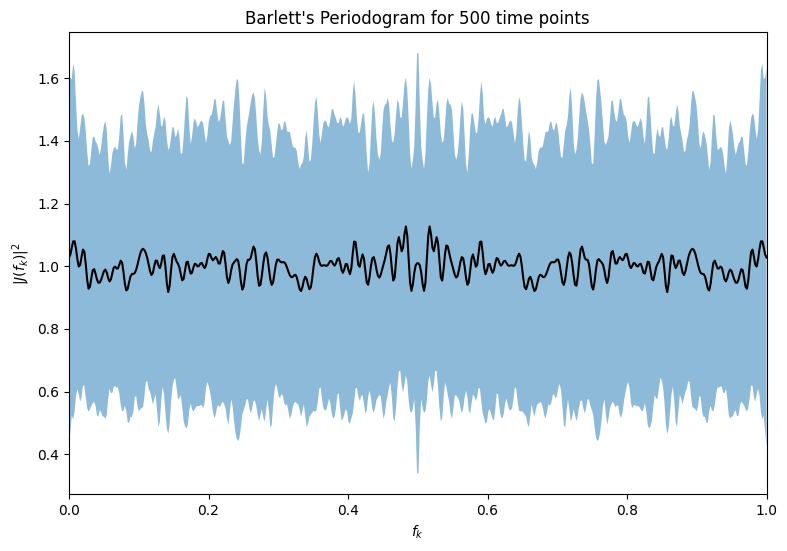

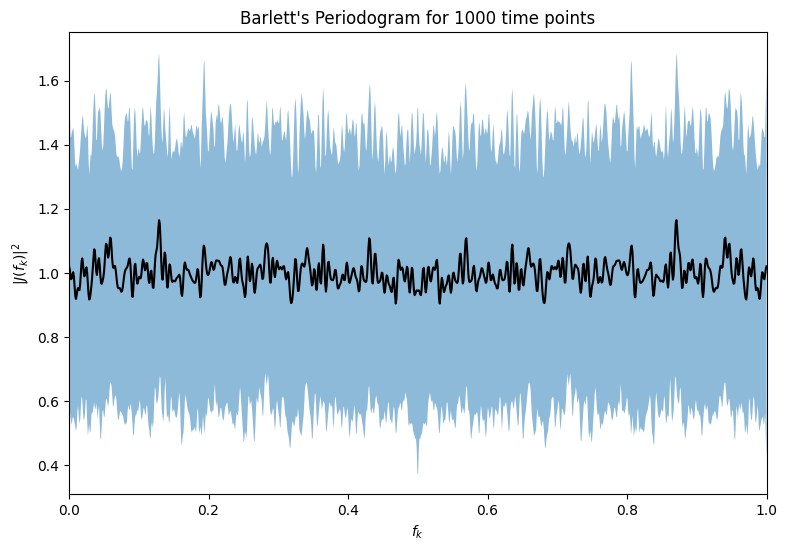

In [6]:
def barlett_estimate(signal, freq, K):
    _, n_points = signal.shape
    split = n_points//K
    res = np.array([periodogram_naive(signal[:,split*i:split*(i+1)], freq) for i in range(K)])
    return np.mean(res, axis=0) # Average over K splits

def plot_barlett(n_points):
    K = 5
    signal, _ = get_data(n_points, sample_freq)
    freqs = np.linspace(0,sample_freq,n_points)
    mod_jfk = [barlett_estimate(signal, freq, K) for freq in freqs]
    ax = plot_with_std(freqs, mod_jfk)

    ax.set_title(f"Barlett's Periodogram for {n_points} time points")
    ax.set_ylabel("$|J (f_k)|^2$")
    ax.set_xlabel("$f_k$")
    if save_fig: 
        plt.savefig(f"images/barlett_{n_points}.png")


for n_points in tested_n_points:
    plot_barlett(n_points)

# Dynamic time warping (DTW)

## Data

This data set consists of signals collected with inertial measurement units (accelerometer+gyroscope), from 230 subjects undergoing a fixed protocol:
- standing still,
- walking 10 m,
- turning around,
- walking back,
- stopping.

In this assignment, we only consider the vertical acceleration of the left foot and all signals are truncated to 20 seconds (as a result, they all have same length). Signals are sampled at 100 Hz.

The measured population is composed of healthy subjects as well as patients with neurological or orthopedic disorders.

The start and end time stamps of thousands of footsteps are available.

The data are part of a larger data set described in [1].

[1] Truong, C., Barrois-Müller, R., Moreau, T., Provost, C., Vienne-Jumeau, A., Moreau, A., Vidal, P.-P., Vayatis, N., Buffat, S., Yelnik, A., Ricard, D., & Oudre, L. (2019). A data set for the study of human locomotion with inertial measurements units. Image Processing On Line (IPOL), 9.

**The task** is to classify footsteps in healthy/non-healthy.

The following cell defines the training set `(X_train, y_train)` and testing set `(X_test, y_test)`.

In [7]:
subset_indexes_train = [95, 619, 441, 149, 951, 803, 214, 34, 37, 630]
subset_indexes_test = [683, 259, 59, 387, 634]

code_list = get_code_list()

X_train = list()  # list of footstep signals
y_train = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_train):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_train.append(signal[start:end])
        y_train.append(label)

        
X_test = list()  # list of footstep signals
y_test = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_test):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_test.append(signal[start:end])
        y_test.append(label)

## Question 10

In [8]:
from dtw import dtw
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier



Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [9]:
# Let's normalize the data:
X_train_norm = [(x-x.mean())/x.std() for x in X_train]
X_test_norm = [(x-x.mean())/x.std() for x in X_test]
y_train = np.array(y_train)

In [10]:
def get_dtw_distance(signal_1,signal_2):
    return dtw(signal_1, signal_2, keep_internals=True).distance

In [11]:
# We compute the distance matrix once 
distance_matrix = np.empty((len(X_train_norm), len(X_train_norm)))
for i in range(len(X_train_norm)):
    for j in range(len(X_train_norm)):
        distance_matrix[i, j]= get_dtw_distance(X_train[i], X_train[j])


In [12]:
# We train the model for different number of neighbors and store the f1 score
f1_scores = []
for k in tqdm(range(1, len(y_train)//2)):
    knn = KNeighborsClassifier(n_neighbors=k, metric="precomputed")
    f1_scores.append(cross_val_score(knn, distance_matrix, np.array(y_train), cv=5, scoring='f1').mean())

100%|██████████| 83/83 [00:02<00:00, 34.93it/s]


/var/folders/h4/q12kpt595_3gn2d_n4g1xcfr0000gn/T/ipykernel_80029/160317424.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Text(0.5, 1.0, 'F1 score with the number of neighbors')

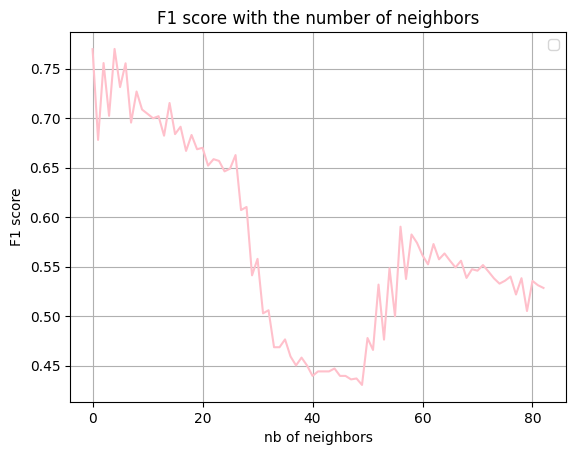

In [13]:
plt.plot(f1_scores, color="pink")
plt.grid()
plt.xlabel("nb of neighbors")
plt.ylabel("F1 score")
plt.legend()
plt.title("F1 score with the number of neighbors")


In [14]:
print(f"The best number of neighbors is {np.argmax(f1_scores)+1} and the f1_score is {np.max(f1_scores):.2f}")

The best number of neighbors is 5 and the f1_score is 0.77


In [15]:
# Testing
# We compute the distance matrix once 
distance_matrix_test = np.empty((len(X_test_norm), len(X_train_norm)))
for i in range(len(X_test_norm)):
    for j in range(len(X_train_norm)):
        distance_matrix_test[i, j]= get_dtw_distance(X_test_norm[i], X_train_norm[j])


In [16]:
knn = KNeighborsClassifier(n_neighbors=5, metric="precomputed")
knn.fit(distance_matrix, y_train)
score = f1_score(np.array(y_test), knn.predict(distance_matrix_test))
print(f"The f1 score for the test set is {score:.2f}.")

The f1 score for the test set is 0.46.


### Conclusion:

We can see that the optimal number of neighbors is **5** with a **validation f1 score of 0.77**. However the associated f1-score with the test dataset is **0.46**.

Our model is not generalizing really well on unseen data.

Maybe we could try to combine more data from the accelerometer in order to have a better result.

## Question 11

In [17]:
result = knn.predict(distance_matrix_test)
mask = (result != y_test) & (result == 1)
ind_health = np.where(mask)

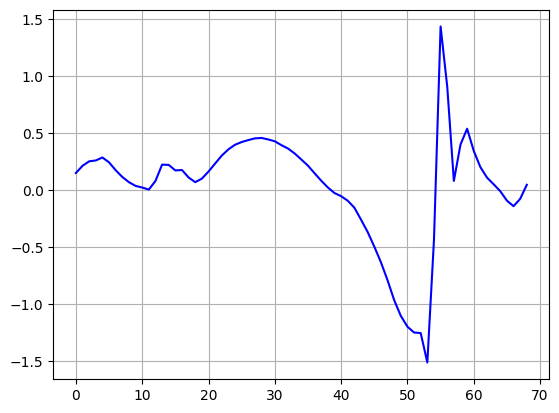

In [18]:
plt.plot(X_test[ind_health[0][0]], color="b")
plt.grid()
plt.savefig("images/healty.png")

In [19]:
mask_un_healthy = (result != y_test) & (result == 0)
ind_un_health = np.where(mask_un_healthy)

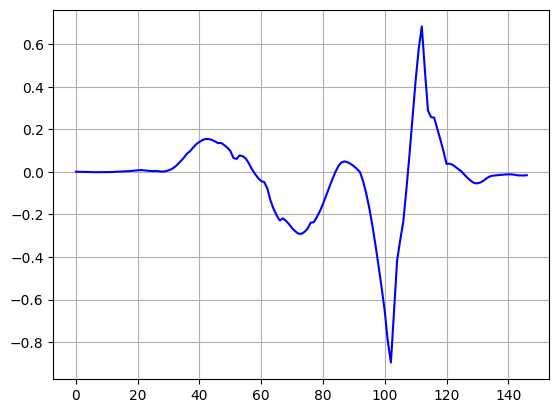

In [20]:
plt.plot(X_test[ind_un_health[0][0]], c='b')
plt.grid()
plt.savefig("images/unhealty.png")